In [1]:
library(raster)
library(sp)
library(repr)

# Setup plot colors and bin sizes
library(wesanderson)
PAL <- wes_palette("Zissou1", 9, type = "continuous")
BREAKS <- c(0, 5, 10, 15, 20, 25, 50, 100, 250, 2000)

Loading required package: sp



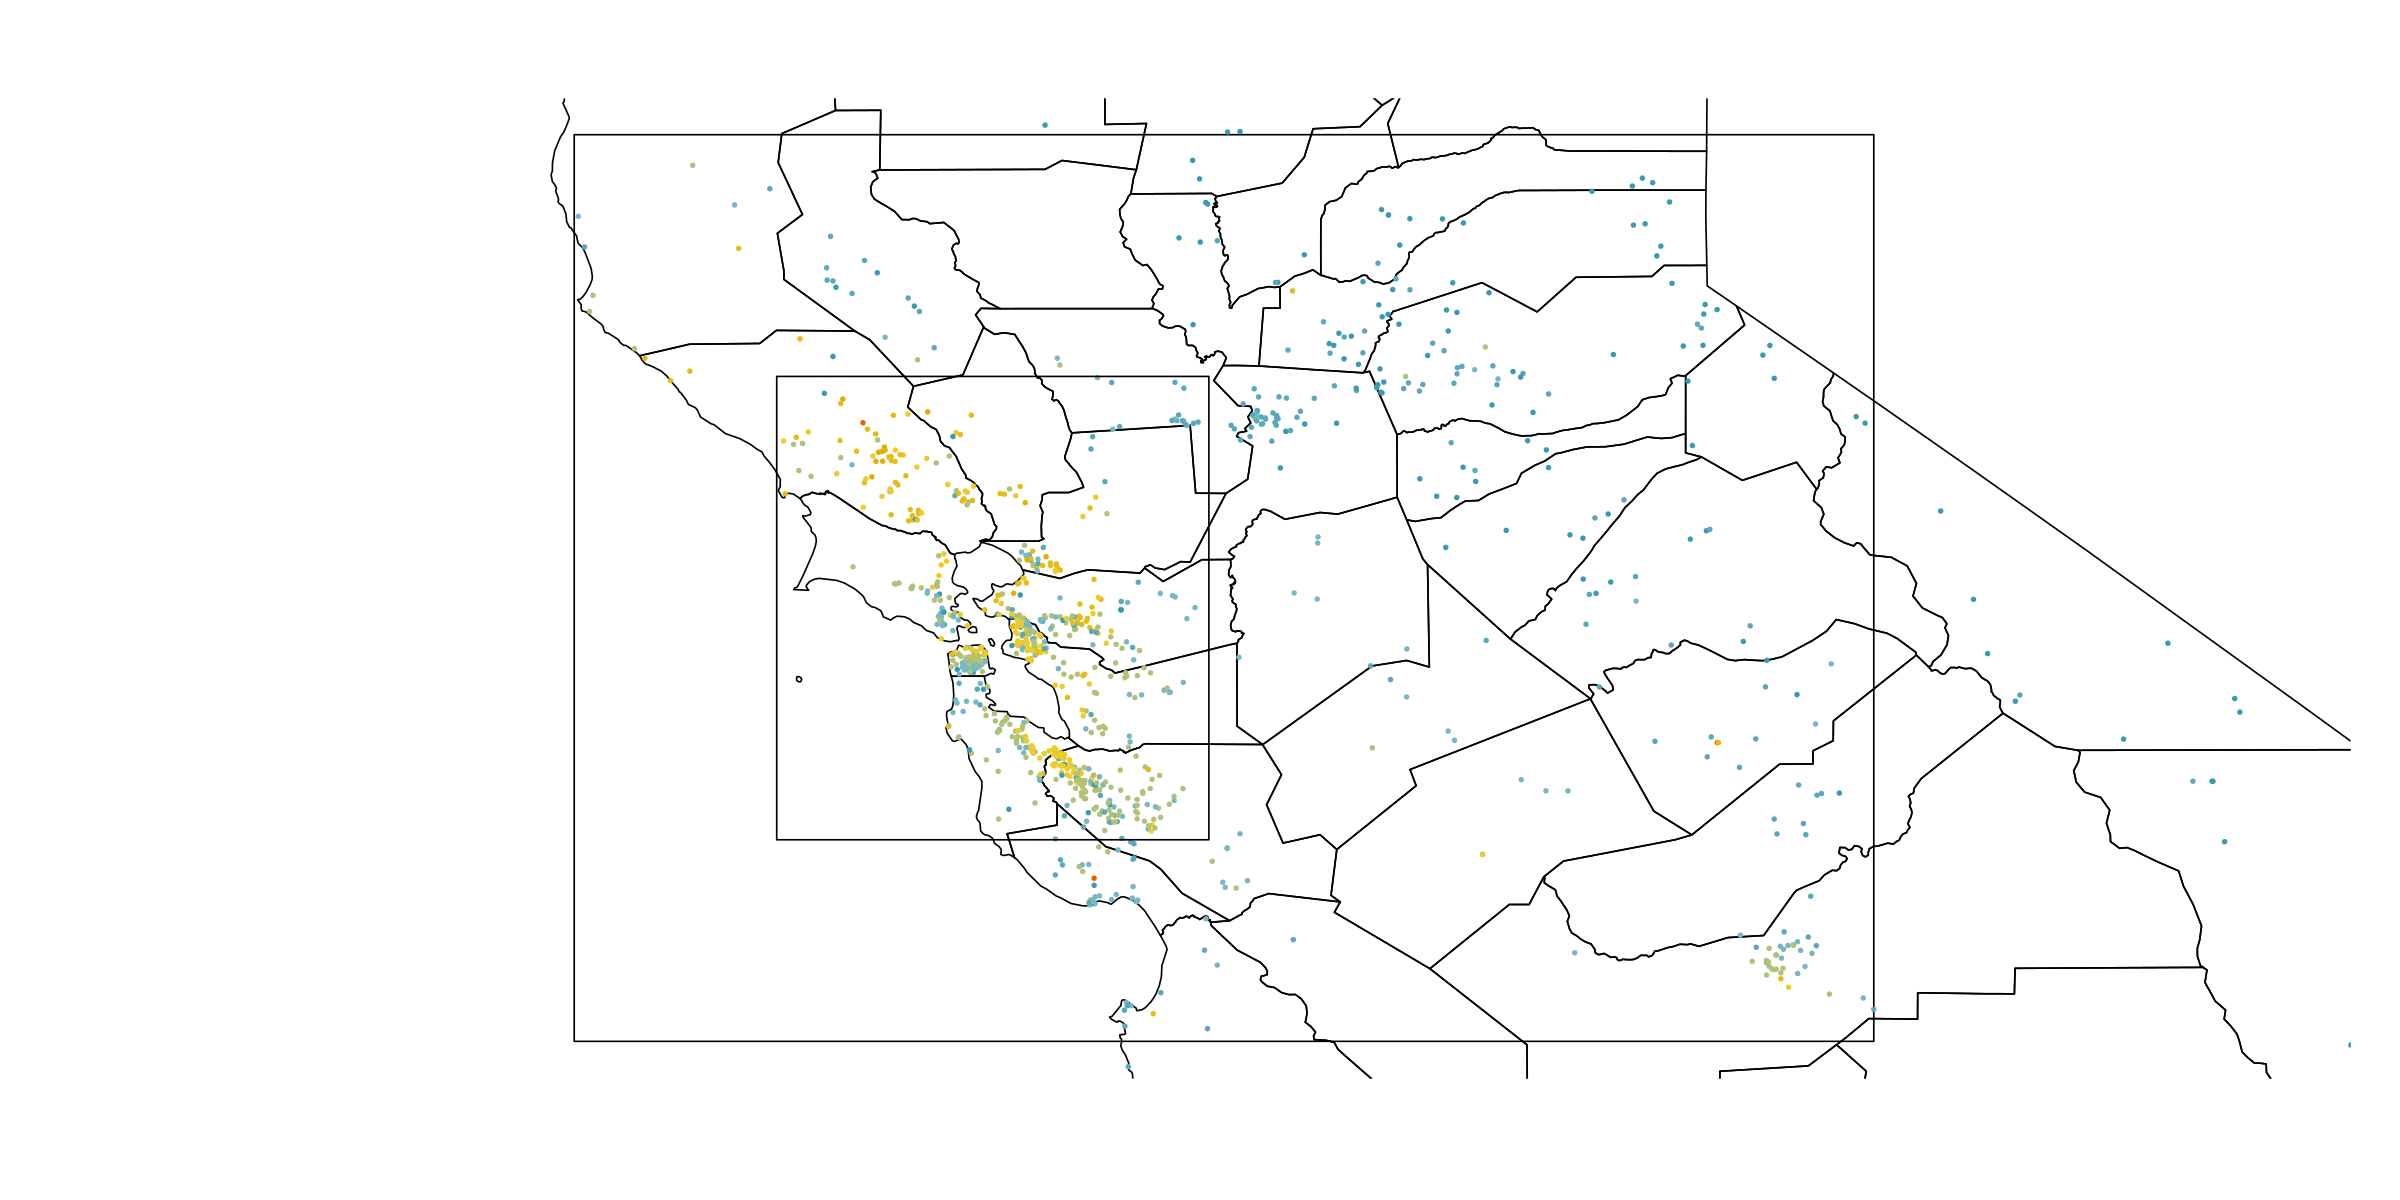

In [2]:
# Work with extents to get a sweet spot of coverage.
bbox <- as(raster::extent(-123.75, -119.45, 36.5, 39.5), "SpatialPolygons") #tweaked MazSatUtils Kincade extent

# Load 2 data sets in to evaluate coverage
load("calif_counties.RData")
load("oct_29_air.RData")


# Basic plot for EDA
options(repr.plot.width=20, repr.plot.height=10)
plot(bbox)
plot(calif_counties, add = TRUE)

# Probabaly could shift East slightly, but let's look at the point coverage first.

# Use the same intervals to generate a new vector colors
binCode <- .bincode(oct_29_air$pm25_1day, BREAKS)
cols_sensor <- PAL[binCode]

points(
  x = oct_29_air$longitude,
  y = oct_29_air$latitude,
  pch = 16,
  cex = 0.5,
  col = cols_sensor
)

# Looks to me like there is a very high coverage in the areas where there are cities.
sf_region <- bbox <- as(raster::extent(-123.08, -121.65, 37.167, 38.7), "SpatialPolygons")
plot(sf_region, add = TRUE)

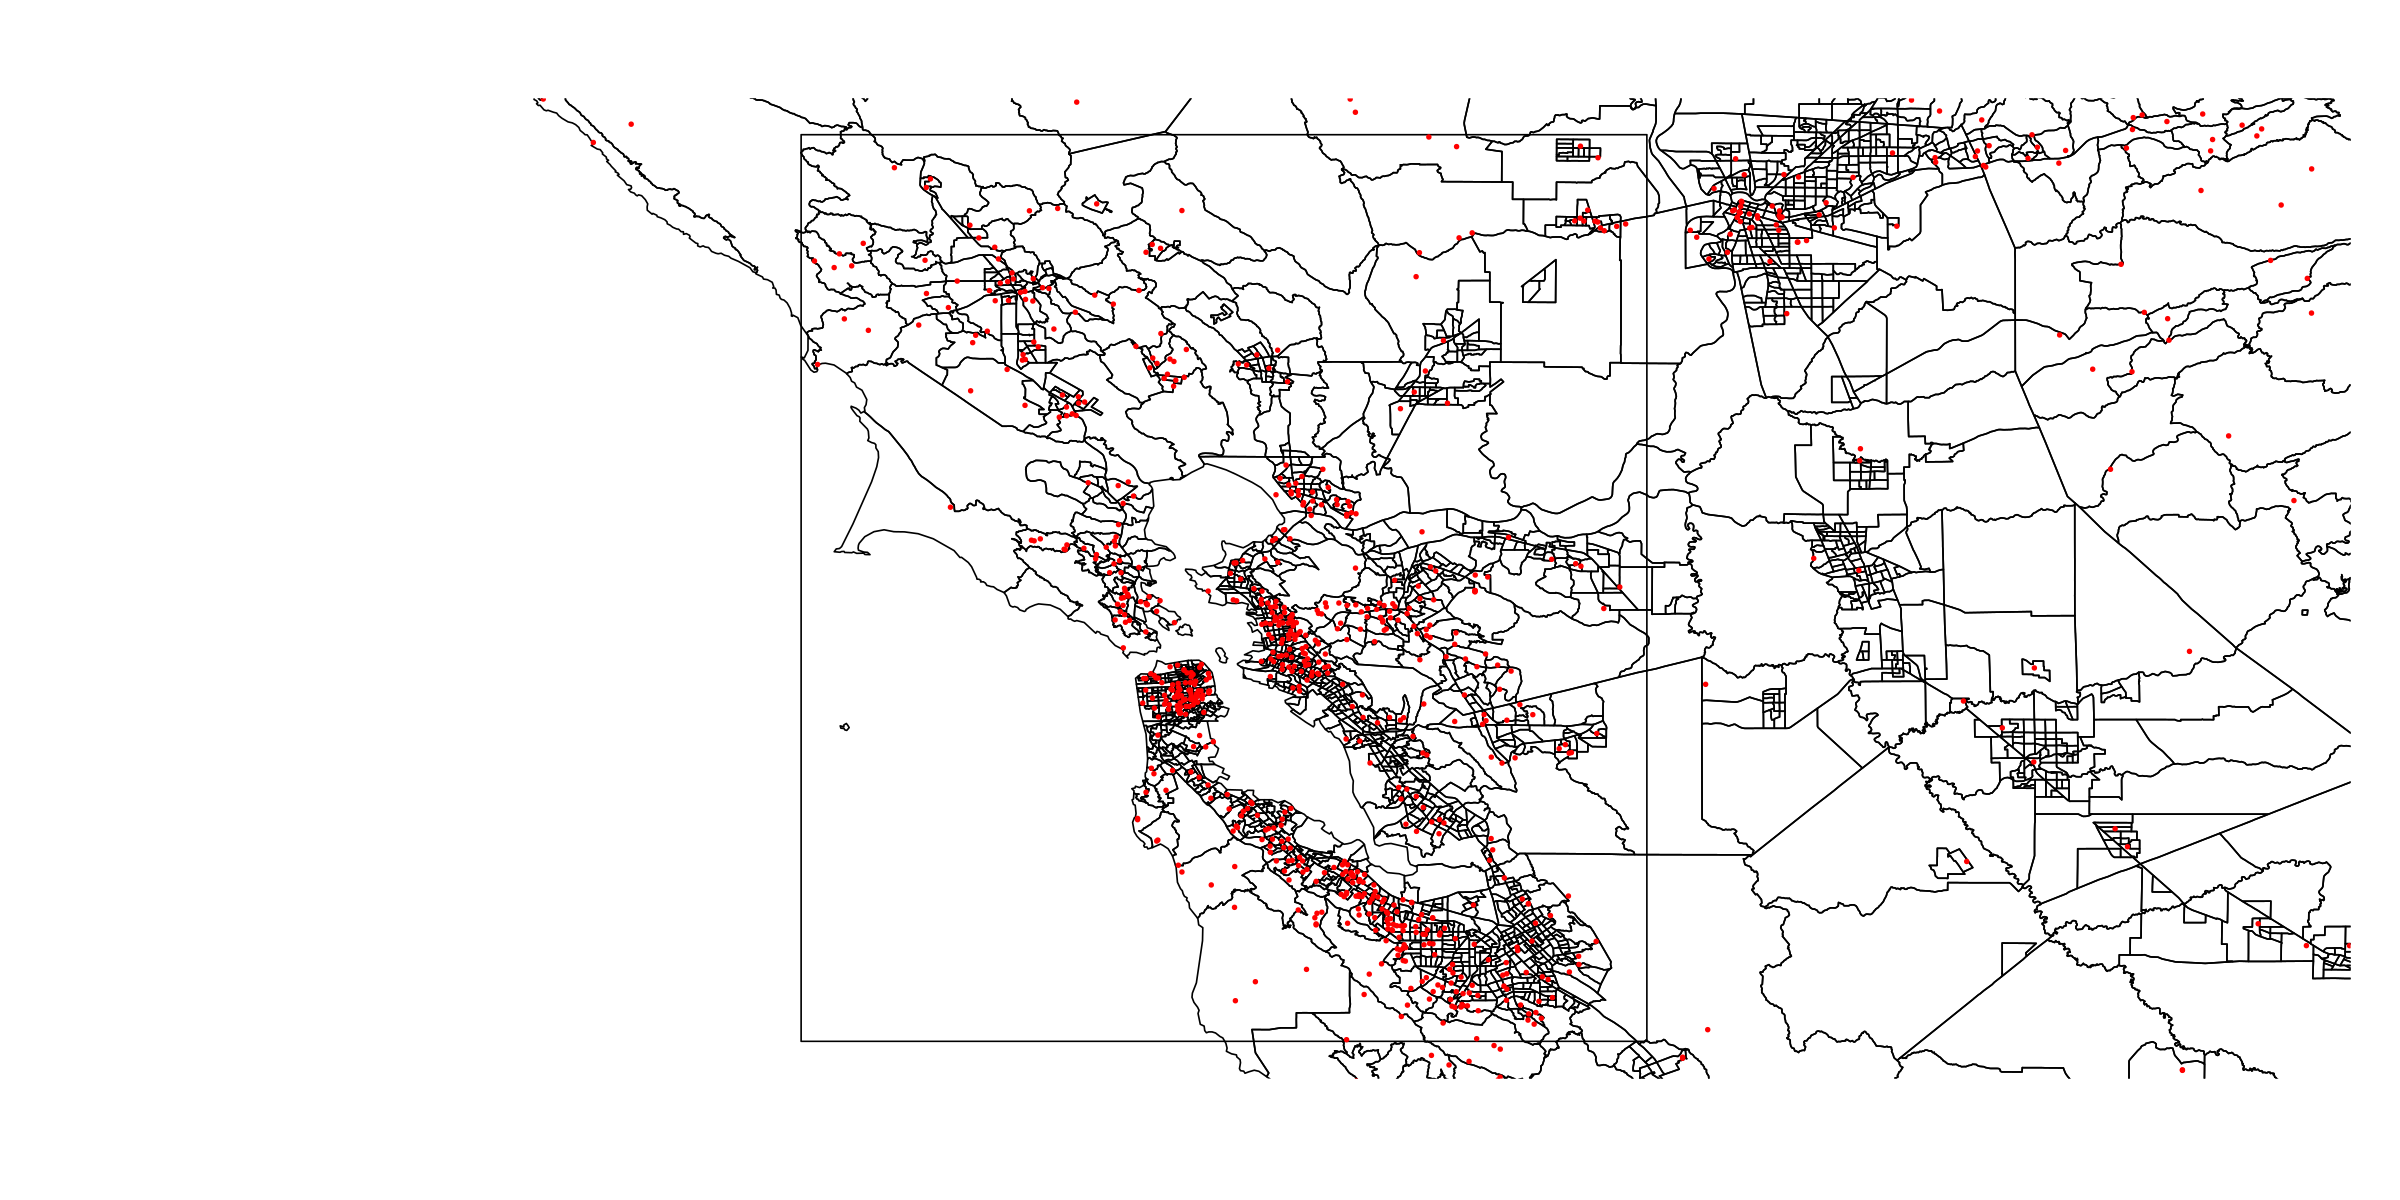

In [3]:
# Sensor point coverage for smaller sf_region, with census tracts
options(repr.plot.width=20, repr.plot.height=10)
sf_region <- bbox <- as(raster::extent(-123.08, -121.65, 37.167, 38.7), "SpatialPolygons")
plot(sf_region)

# Very dense, but it does show us metro regions nicely.
load("ca_census_tracts.RData")
plot(ca_census_tracts, add = TRUE)

# What do the sensor points look like?
points(
  x = oct_29_air$longitude,
  y = oct_29_air$latitude,
  pch = 16,
  cex = 0.5,
  col = "red"
)

# Going to start with that as my initial clipping extent

Loading required namespace: rgeos



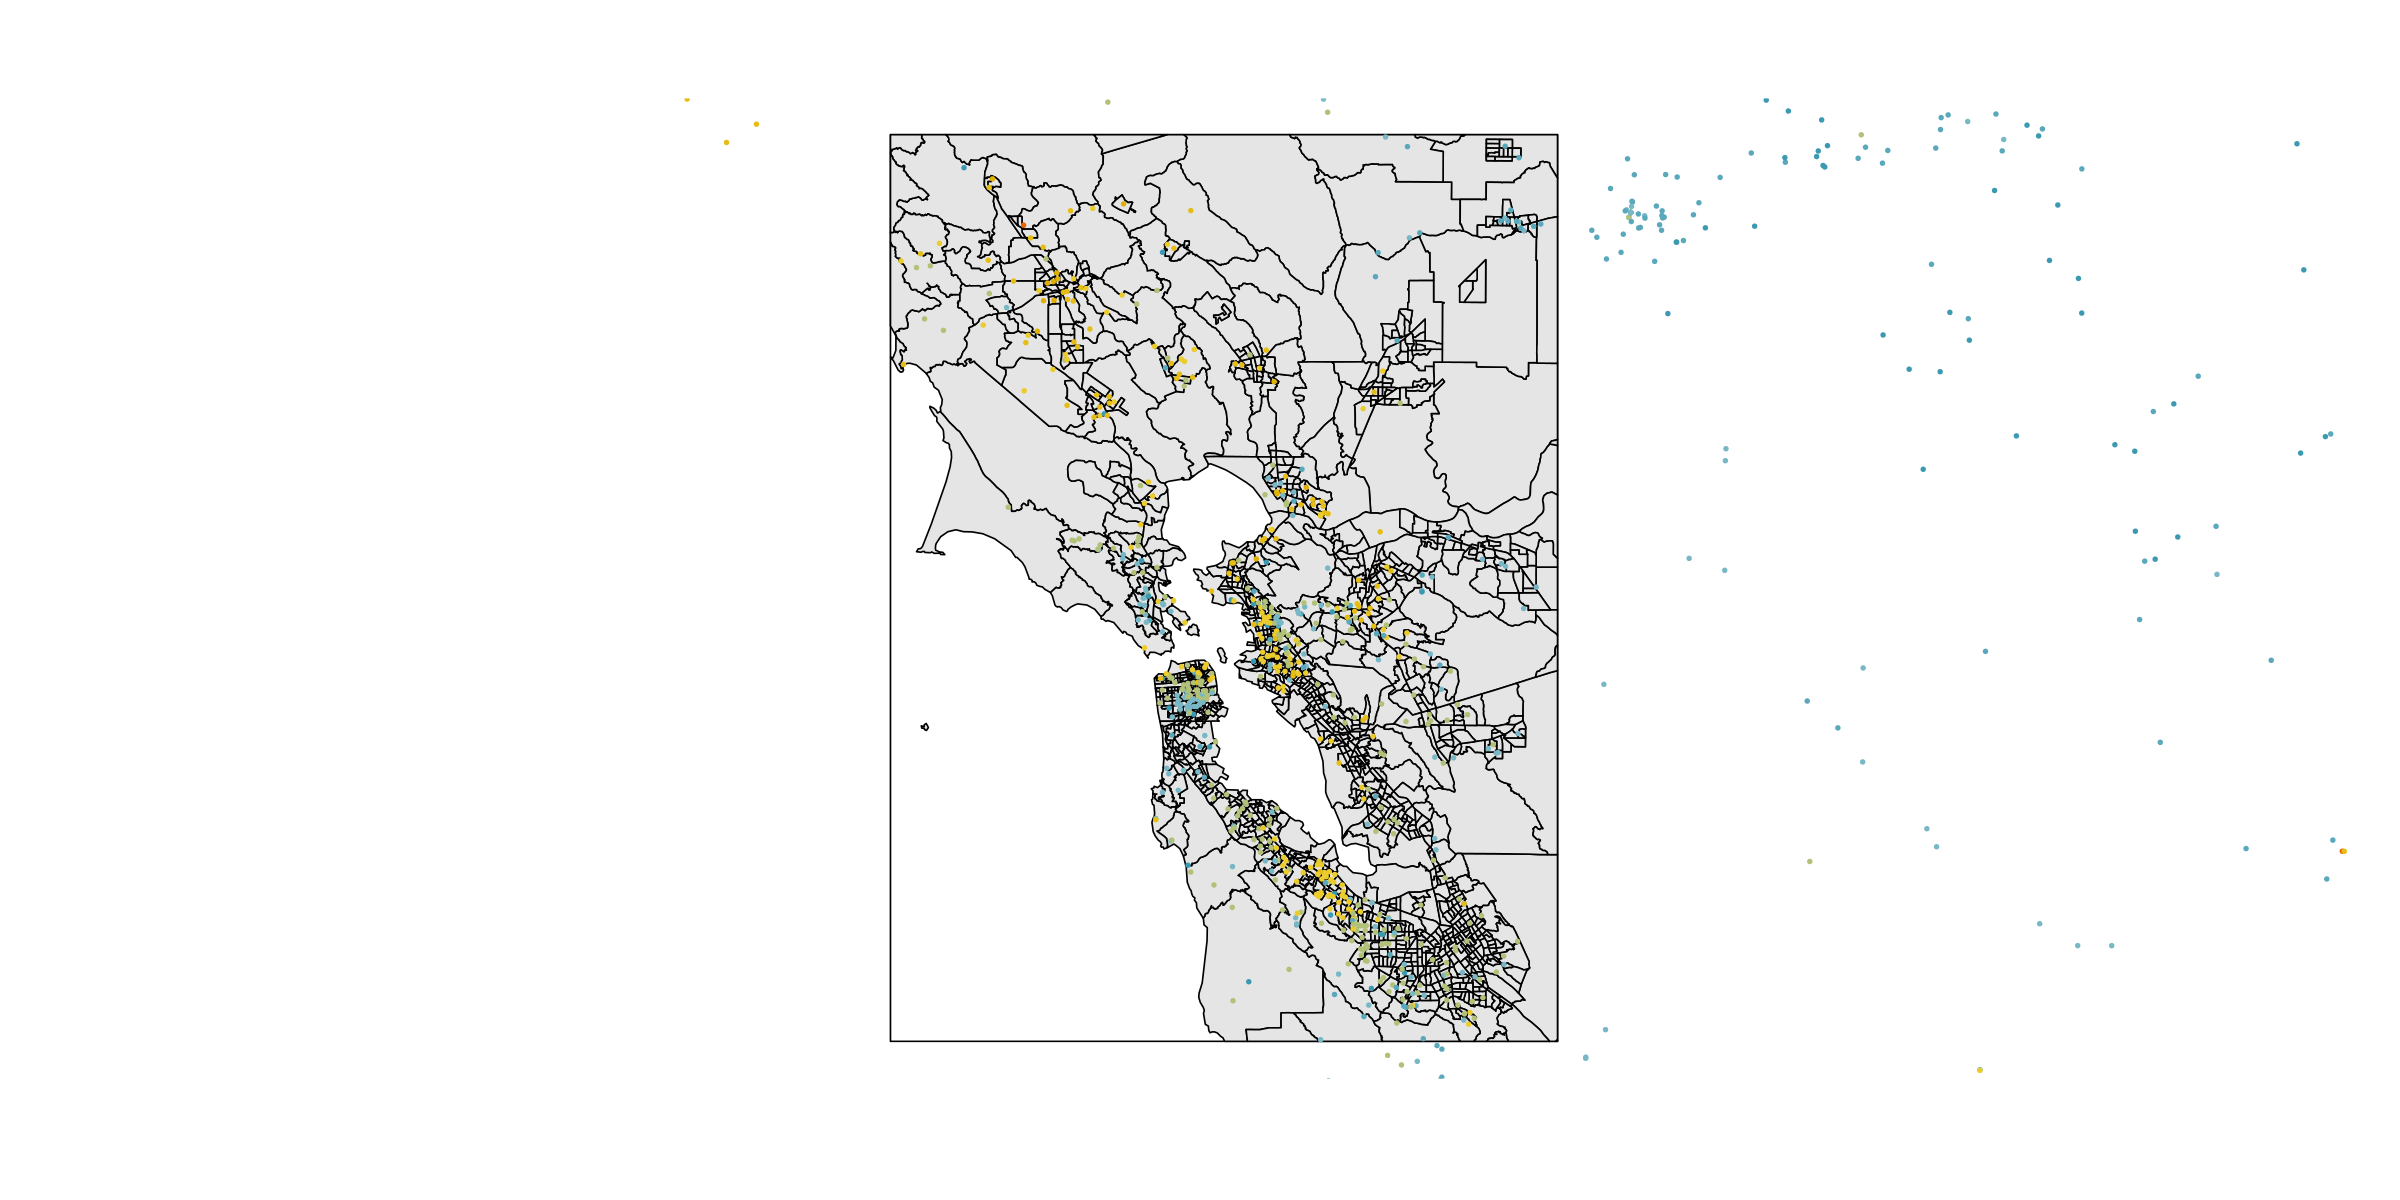

In [4]:
# Clip census tracts and counties to sf_region

simpleClip <- function(
    # Returns the intersection of spdf_1 and spdf 2
    # but only returns attributes for spdf_1
    spdf_1,
    spdf_2
) {
    clipped <- raster::intersect(spdf_1, spdf_2)
    keepN <- ncol(spdf_1@data) # Only keep the 1st N cols that belong to spdf_1
    data <- clipped@data[1:keepN]
    names(data) <- sub("\\.1", "", colnames(data))
    clipped@data <- data
    return(clipped)
}

# Set clip region to common projection
proj <- CRS("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs +towgs84=0,0,0")
proj4string(sf_region) <- proj

# Clip the tracts to the extents of the sf_region
sf_region_tracts <- simpleClip(ca_census_tracts, sf_region)

# Plot the results
plot(sf_region)
plot(sf_region_tracts, col = "gray90", add = TRUE)

points(
  x = oct_29_air$longitude,
  y = oct_29_air$latitude,
  pch = 16,
  cex = 0.5,
  col = cols_sensor
)

In [5]:
# Convert air_data into SpatialPointsDataFrame
oct_29_air_df <- data.frame(pm25_1day = oct_29_air$pm25_1day,
                            longitude = oct_29_air$longitude,
                            latitude = oct_29_air$latitude)

xy <- oct_29_air_df[c("longitude", "latitude")]

oct_29_air_spdf <- SpatialPointsDataFrame(coords = xy, data = oct_29_air_df, proj4string = proj)

# Spatially subset the points to just those inside the sf_region
sf_region_oct_29_air <- simpleClip(oct_29_air_spdf, sf_region)

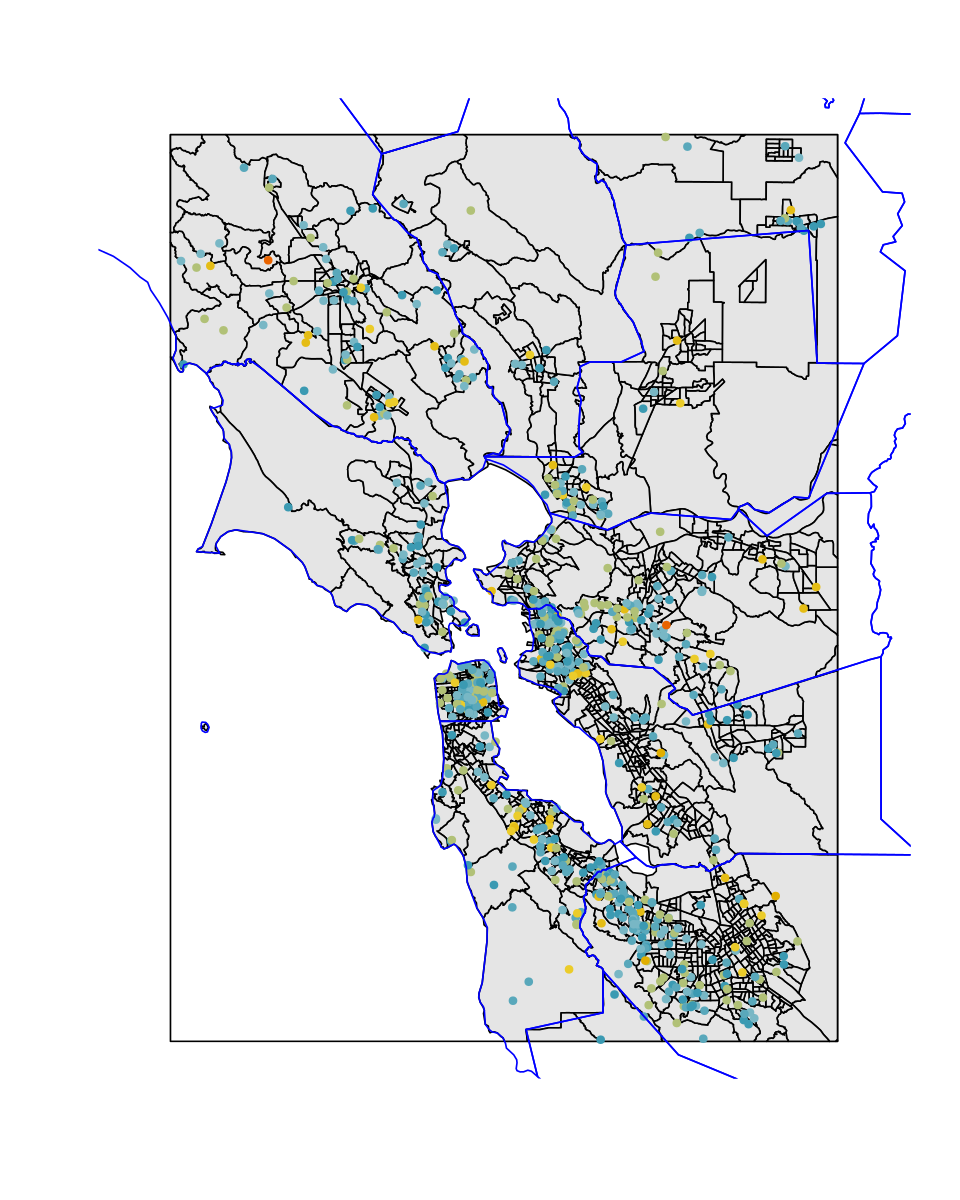

In [6]:
# Plot the clipped data
options(repr.plot.width=8, repr.plot.height=10)
#par( mfrow = c(1,1), mar=c(.1,.1,.1,.1))

plot(sf_region)
plot(sf_region_tracts, col = "gray90", add = TRUE)
plot(sf_region_oct_29_air,
     pch = 16,
     cex = .85,
     col = cols_sensor, 
     add = TRUE)

# Superimpose county borders... and it's clear they are overly simplified and don't match the tracts
plot(calif_counties, border = "blue", add = TRUE)

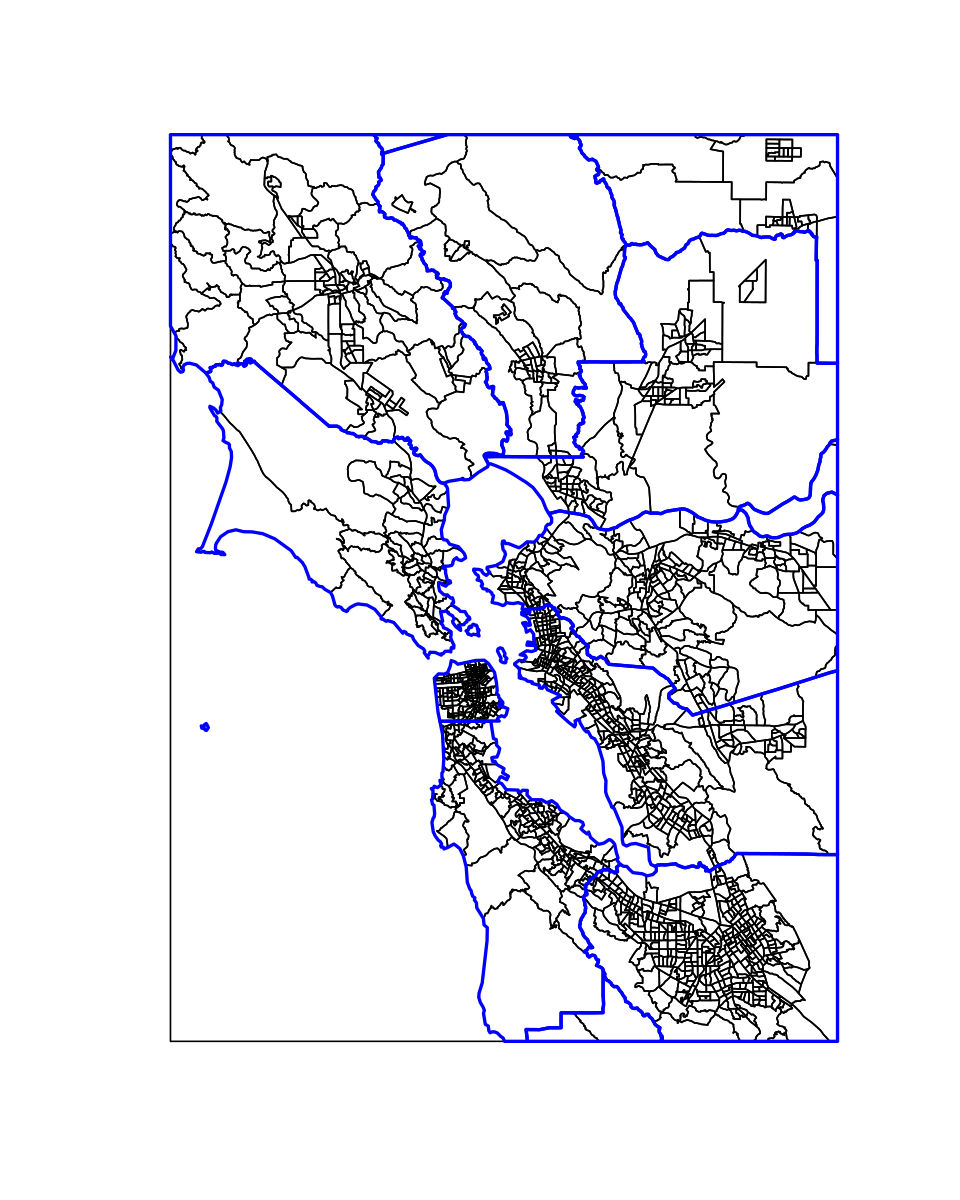

In [7]:
# Aggregate up the census tracts into counties and see what they look like over tracts
sf_region_counties <- raster::aggregate(sf_region_tracts, 
                                        by='COUNTYFP', 
                                        sums=list(list(function(x)x[1], c('STATEFP')  )))
                                                       
plot(sf_region)
plot(sf_region_tracts, add = TRUE)
plot(sf_region_counties, border = "blue", lwd = 2, add = TRUE)

# Better

In [8]:
# Color the census tracts using the same colors. This means that for every point, I want to assign it a
# census_tract_id.  Easiest way to do that is to intersect the tracts with the points.

point_tract_codes <- sp::over(sf_region_oct_29_air, sf_region_tracts[,"TRACTCE"])

sf_region_oct_29_air@data$TRACTCE <- point_tract_codes$TRACTCE
head(sf_region_oct_29_air@data)

,pm25_1day,longitude,latitude,TRACTCE
,<dbl>,<dbl>,<dbl>,<chr>
1,14.61,-121.9641,37.27556,506702
2,13.72,-122.4393,37.72244,026100
3,12.87,-122.4394,37.72246,026100
4,22.40,-122.4392,37.72242,026100
5,14.37,-122.4392,37.72238,026100
6,14.49,-122.4391,37.72241,026100


In [9]:
# Now what I want is to aggregate this data by TRACTCE, taking the median of all pm25_1day values for every
# tract

oct_29_air_median_by_tract <- aggregate(sf_region_oct_29_air$pm25_1day, 
                                        list(sf_region_oct_29_air$TRACTCE), 
                                        median)
names(oct_29_air_median_by_tract) = c('TRACTCE', 'oct_29_pm25')
head(oct_29_air_median_by_tract)

,TRACTCE,oct_29_pm25
,<chr>,<dbl>
1,010401,9.46
2,010500,20.33
3,010510,8.54
4,010512,8.44
5,010600,21.66
6,010602,10.24


In [10]:
#  Now I need to tie the 'oct_29_pm25' values back to every 'TRACTCE' in 'sf_region_oct_29_air' that matches

sf_region_tracts@data <- merge(sf_region_tracts@data, oct_29_air_median_by_tract, by = 'TRACTCE')

subset(sf_region_tracts@data, sf_region_tracts@data$TRACTCE == '026100')

,TRACTCE,STATEFP,COUNTYFP,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,oct_29_pm25
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
52,026100,06,075,1400000US06075026100,06075026100,261,CT,751208,0,13.75


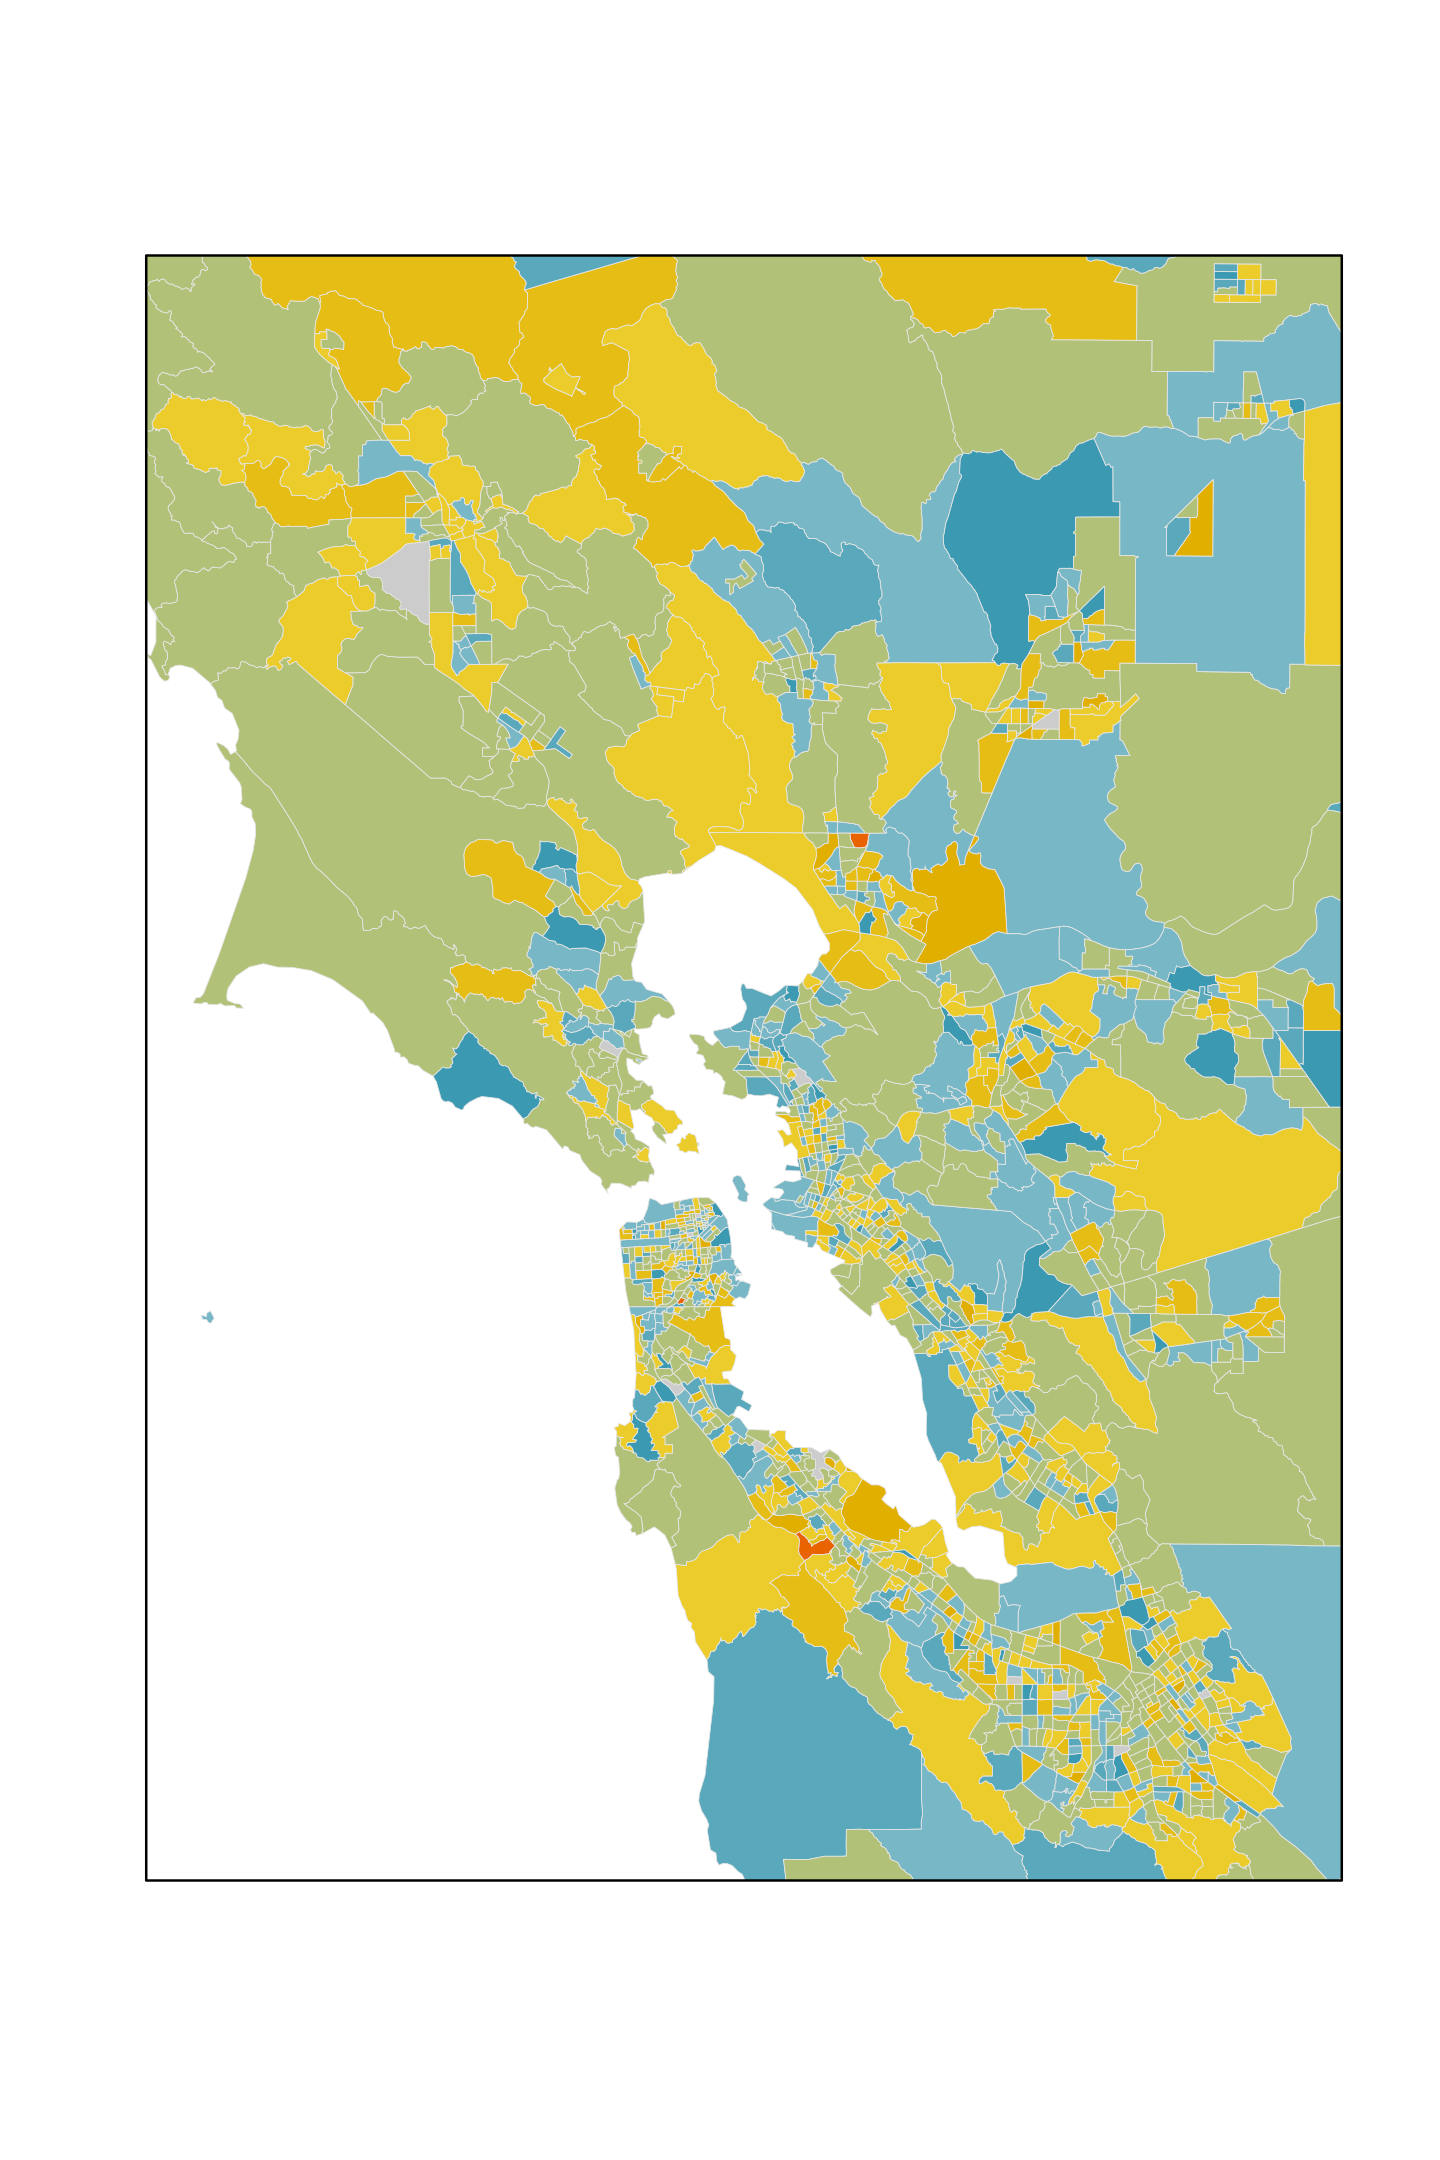

In [18]:
# Now to plot the census tracts using the aggregated pm25 values
options(repr.plot.width=12, repr.plot.height=18)


# Use the same intervals to generate a new vector colors
binCode <- .bincode(sf_region_tracts$oct_29_pm25, BREAKS)
cols_tract <- PAL[binCode]

# Change NA to "#bbbbbb" so that we get gray instead of white for NA counties
cols_tract[is.na(cols_tract)] <- "#CCCCCC"

# Chloropleth map
plot(sf_region_tracts, col = cols_tract, border = "gray90", lwd = 0.5)
plot(sf_region, add = TRUE, lwd = 1.5)
